In [39]:
## SIMULATE TCS using POISSON PROCESS WITH MONTHLY RATE ???
## SANITY CHECK FOR CMIP


In [40]:
from utils.cyclone_utils import get_datetime
import pandas as pd


## CYCLONE MASTER DF
cyclone_df = pd.read_csv('../cyclone_data/jtwc/cleaned/full_instantaneous.csv')
cyclone_df['month'] = cyclone_df['timestamp'].apply(lambda x: get_datetime(x).month) 
cyclone_df


,timestamp,Storm ID,BASIN,Season,SEASON TC NUMBER,STORMNAME,Latitude (degrees),Longitude (degrees),VMAX (kt),Peak VMAX (kt),ACE,Maximum 24h Intensification,Tropical SST,Global SST,Local SST,Local Month Mean,Local Anomaly,Saffir-Simpson Category,month
0,1982-03-14 06:00:00,1982-N-1,WP,1982.0,1.0,NaN,7.1,153.0,15.0,60.0,0.73250,15.0,27.961514,13.499058,28.082220,28.562027,-0.479807,1,3
1,1981-10-21 06:00:00,1982-S-2,SI,1982.0,2.0,NaN,-8.0,84.6,40.0,85.0,1.18725,25.0,27.240122,13.386498,28.012896,27.828356,0.184540,2,10
2,1982-03-18 06:00:00,1982-N-2,WP,1982.0,2.0,NaN,3.8,160.7,25.0,105.0,2.02800,25.0,27.961514,13.499058,29.003502,28.968107,0.035395,3,3
3,1982-03-28 06:00:00,1982-N-3,WP,1982.0,3.0,NaN,3.5,156.6,20.0,75.0,0.70650,15.0,27.961514,13.499058,28.872086,29.140408,-0.268322,1,3
4,1981-12-05 00:00:00,1982-S-4,AUS,1982.0,4.0,NaN,-11.9,125.0,45.0,45.0,0.04850,-10.0,27.350914,13.314075,29.079239,30.004630,-0.925390,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1806,2022-10-14 06:00:00,2022-N-24,WP,2022.0,24.0,INVEST,26.4,154.4,25.0,40.0,0.19675,15.0,27.271444,13.853819,28.137896,27.757618,0.380278,1,10
1807,2022-10-26 00:00:00,2022-N-26,WP,2022.0,26.0,INVEST,12.2,133.8,20.0,75.0,0.67825,25.0,27.271444,13.853819,29.645842,29.207080,0.438761,1,10
1808,2022-10-28 12:00:00,2022-N-27,WP,2022.0,27.0,INVEST,8.0,140.4,25.0,40.0,0.10875,15.0,27.271444,13.853819,29.821840,29.312254,0.509586,1,10
1809,2022-11-11 18:00:00,2022-N-28,WP,2022.0,28.0,INVEST,20.2,166.3,20.0,40.0,0.10600,10.0,27.478075,13.700613,28.148760,27.703903,0.444857,1,11


In [41]:
## Split into basins and calculate rates for each calendar month
dfs = {}
for basin_name in cyclone_df['BASIN'].unique():
    dfs[basin_name] = cyclone_df.loc[cyclone_df.loc[:, 'BASIN'] == basin_name]

## rate = mean occurrence per month....
rates = {}
basin_boundaries = {}

for basin_name in dfs.keys():
    basin_df = dfs[basin_name]
    BASIN_NUM_SEASONS = basin_df['Season'].max() - basin_df['Season'].min()
    # basin_boundaries[basin_name] = {
    #     'lat': {
    #         'min': basin_df['Latitude (degrees)'].min(),
    #         'max': basin_df['Latitude (degrees)'].max()
    #     },
    #     'lon': {
    #         'min': basin_df['Longitude (degrees)'].min(),
    #         'max': basin_df['Longitude (degrees)'].max()
    #     }
    # }

    for month in range(1,13):
        ## probably faster with groupby
        basin_month_num_cyclones = basin_df.loc[basin_df.loc[:, 'month'] == month].shape[0]
        avg_month_rate = basin_month_num_cyclones/BASIN_NUM_SEASONS
        if basin_name not in rates.keys():
            rates[basin_name] = {}
        rates[basin_name][month] = avg_month_rate
        

In [42]:
## uni

## Sample some cyclones for each basin

In [43]:
from datetime import datetime, timedelta
import numpy as np

def get_start_of_next_month(dt):
    month = dt.month
    year = dt.year
    if month == 12:
        return datetime.strptime(f'{year + 1}-01-01', "%Y-%m-%d")
    
    return datetime.strptime(f'{year}-{month + 1}-01', "%Y-%m-%d")

new_cyclones = None

for basin_name in rates.keys():
    start_time = None;
    end_time = None
    basin_df = dfs[basin_name]

    if basin_name == 'WP':
        ## should we only filter by cyclone seasons
        start_time = datetime.strptime("1982-01-01", "%Y-%m-%d")
        end_time = datetime.strptime("2022-12-31", "%Y-%m-%d")
    else:
        start_time = datetime.strptime("1982-07-01", "%Y-%m-%d")
        end_time = datetime.strptime("2021-06-30", "%Y-%m-%d")

    current_time = start_time
    while current_time < end_time:
        current_month = current_time.month
        current_rate = rates[basin_name][current_month]
        if current_rate == 0:
            current_time = get_start_of_next_month(current_time)
        else:
            months_till_cyclone = np.random.exponential(1/current_rate)
            delta = timedelta(days = months_till_cyclone * (365.25/12))
            time_of_start = current_time + delta
            if time_of_start.month != current_time.month:
                current_time = get_start_of_next_month(current_time)
            else:

                time_of_start = current_time + delta

                ## SAMPLE ITS LOCATION AND ADD TO DATAFRAME
                ## ATM JUST UNIFORMLY...

                ## add some gaussian noise....
                # lat_noise = np.random.normal(0,1)
                # lon_noise = np.random.normal(0,2)

                coord_pairs = np.array(list(zip(basin_df['Latitude (degrees)'], basin_df['Longitude (degrees)'])))
                index = np.random.choice(coord_pairs.shape[0], 1)
                coord = coord_pairs[index][0]

                lat = coord[0]
                lon = coord[1]

                cyclone_obj = {
                    'timestamp': [datetime.strftime(time_of_start, '%Y-%m-%d')],
                    'lat': [lat],
                    'lon': [lon],
                    'BASIN': [basin_name]
                }

                print(cyclone_obj)

                new_cyclone = pd.DataFrame(cyclone_obj)
                if new_cyclones is None:
                    new_cyclones = new_cyclone
                else:
                    new_cyclones = pd.concat([new_cyclones, new_cyclone])

                # current_time += delta
                current_time = time_of_start
        

new_cyclones
    


{'timestamp': ['1982-01-17'], 'lat': [20.3], 'lon': [152.2], 'BASIN': ['WP']}
{'timestamp': ['1982-03-16'], 'lat': [16.3], 'lon': [178.3], 'BASIN': ['WP']}
{'timestamp': ['1982-06-17'], 'lat': [20.7], 'lon': [135.8], 'BASIN': ['WP']}
{'timestamp': ['1982-07-02'], 'lat': [13.2], 'lon': [143.8], 'BASIN': ['WP']}
{'timestamp': ['1982-07-06'], 'lat': [6.1], 'lon': [182.2], 'BASIN': ['WP']}
{'timestamp': ['1982-07-18'], 'lat': [13.5], 'lon': [166.5], 'BASIN': ['WP']}
{'timestamp': ['1982-07-31'], 'lat': [20.0], 'lon': [152.0], 'BASIN': ['WP']}
{'timestamp': ['1982-08-13'], 'lat': [16.5], 'lon': [168.8], 'BASIN': ['WP']}
{'timestamp': ['1982-08-18'], 'lat': [6.7], 'lon': [197.0], 'BASIN': ['WP']}
{'timestamp': ['1982-08-29'], 'lat': [5.5], 'lon': [170.5], 'BASIN': ['WP']}
{'timestamp': ['1982-09-03'], 'lat': [7.3], 'lon': [131.8], 'BASIN': ['WP']}
{'timestamp': ['1982-09-12'], 'lat': [18.1], 'lon': [152.3], 'BASIN': ['WP']}
{'timestamp': ['1982-09-13'], 'lat': [12.0], 'lon': [144.0], 'BASIN'

,timestamp,lat,lon,BASIN
0,1982-01-17,20.3,152.2,WP
0,1982-03-16,16.3,178.3,WP
0,1982-06-17,20.7,135.8,WP
0,1982-07-02,13.2,143.8,WP
0,1982-07-06,6.1,182.2,WP
...,...,...,...,...
0,2021-02-03,-7.9,180.5,SP
0,2021-02-06,-13.2,163.3,SP
0,2021-02-22,-8.2,163.5,SP
0,2021-03-14,-14.0,162.4,SP


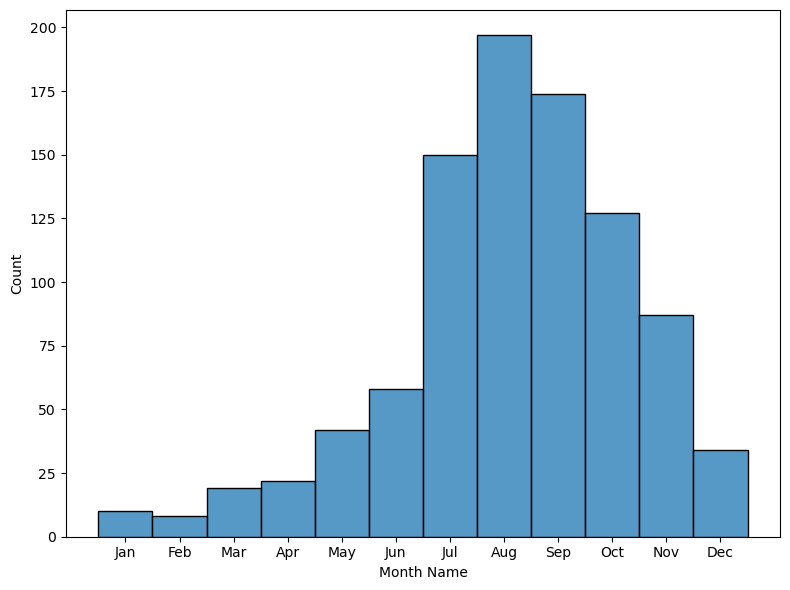

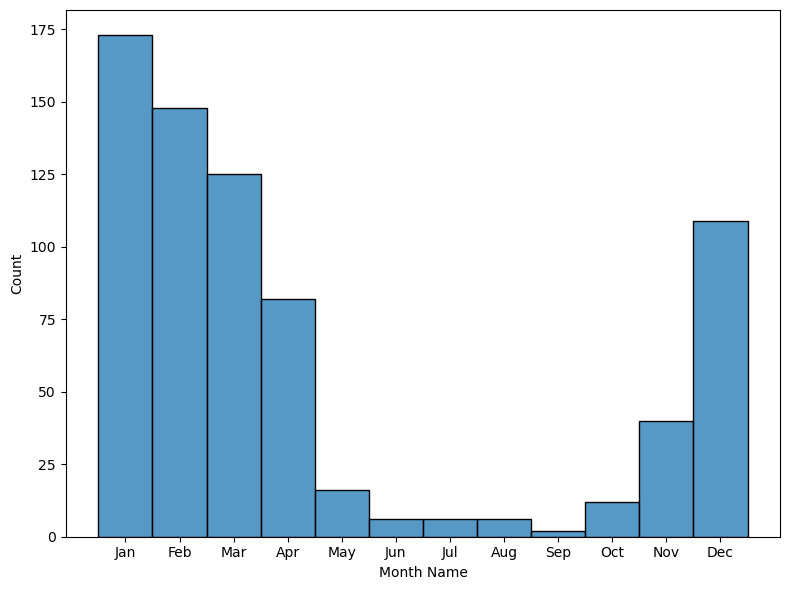

In [44]:
## Check month distribution
import matplotlib.pyplot as plt
import seaborn as sns

new_cyclones['month'] = new_cyclones['timestamp'].apply(lambda t: datetime.strptime(t, '%Y-%m-%d').month)
new_cyclones = new_cyclones.sort_values(by=['month'])
new_cyclones['Month Name'] = new_cyclones['timestamp'].apply(lambda t: datetime.strptime(t, '%Y-%m-%d').strftime('%b'))

fig, ax = plt.subplots(figsize=(8, 6))
# NORTHERN HEMISPHERE
sns.histplot(new_cyclones.loc[new_cyclones.loc[:, 'BASIN'] == 'WP'], x='Month Name',binwidth=3)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(new_cyclones.loc[new_cyclones.loc[:, 'BASIN'] != 'WP'], x='Month Name',binwidth=3)
plt.tight_layout()
plt.show()

latitude: -22.6 to 28.6
longitude: 35.8 to 228.6


/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/albertdemskoy/mambaforge/envs/climateProjectEnv/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


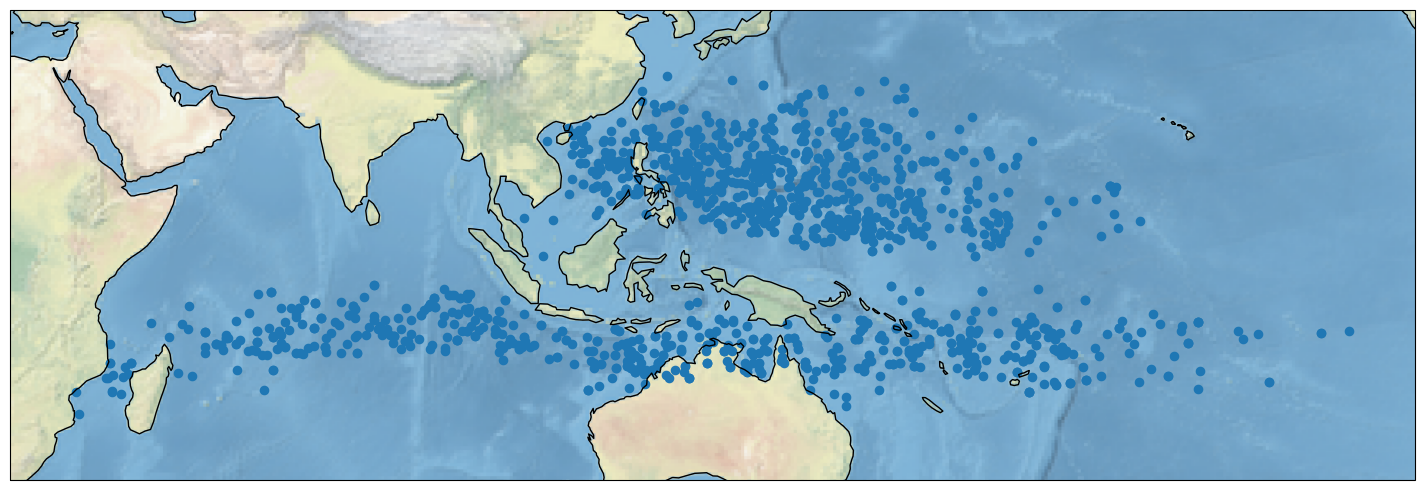

In [45]:

# %matplotlib inline
from matplotlib import pyplot as plt
import cartopy.crs as ccrs

## only show origin sites for now
min_long = new_cyclones['lon'].min()
min_lat = new_cyclones['lat'].min()

max_long = new_cyclones['lon'].max()
max_lat = new_cyclones['lat'].max()

centre_long = (max_long-min_long)/2

print('latitude: ' + str(min_lat) + ' to ' + str(max_lat))
print('longitude: ' + str(min_long) + ' to ' + str(max_long))

height = 5
fig = plt.figure(figsize=((max_long - min_long)/(max_lat-min_lat)*height, height))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude= centre_long))
ax.set_extent([min_long - 10, max_long + 10 ,min_lat - 10,max_lat + 10], ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()

scatter = plt.scatter(x=new_cyclones['lon'], y=new_cyclones['lat'], transform=ccrs.PlateCarree(), s=35)

fig.tight_layout()
plt.show()

# fig.savefig('./media/Cyclone/cyclone_map/all_cyclones.png')

In [46]:
from utils.SST_utils import get_cmip_historical, get_tropical_avg, get_local_smooth_at_time, sel_mm_yyyyy, get_local_mean

cmip_historical = get_cmip_historical()

cmip_historical = cmip_historical.sel(time=(cmip_historical.time.dt.year >= 1980))['tos_mean_mean'].rename({'latitude': 'lat', 'longitude': 'lon'}) # no point hoarding old data
cmip_historical


<xarray.DataArray 'tos_mean_mean' (time: 420, lat: 192, lon: 288)>
[23224320 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1980-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat      (lat) float64 -89.53 -88.59 -87.66 -86.72 ... 87.66 88.59 89.53
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

In [47]:
cmip_tropical_avg = get_tropical_avg(cmip_historical).rolling(time=12).mean().dropna(dim='time')
cmip_tropical_avg

<xarray.DataArray 'tos_mean_mean' (time: 409)>
array([27.808622, 27.805994, 27.807281, 27.80974 , 27.810493, 27.812775,
       27.81649 , 27.820618, 27.825089, 27.828966, 27.832762, 27.83625 ,
       27.839842, 27.843523, 27.847166, 27.850237, 27.852587, 27.853258,
       27.85353 , 27.853996, 27.854769, 27.85537 , 27.854761, 27.853806,
       27.851954, 27.849394, 27.843636, 27.836525, 27.829315, 27.82467 ,
       27.821238, 27.818283, 27.816635, 27.815   , 27.813395, 27.812317,
       27.810698, 27.80813 , 27.805298, 27.803846, 27.802736, 27.798706,
       27.791952, 27.784178, 27.774878, 27.766027, 27.757765, 27.750204,
       27.74373 , 27.739649, 27.736235, 27.732485, 27.730133, 27.730135,
       27.734285, 27.7407  , 27.749186, 27.759056, 27.768892, 27.779053,
       27.78994 , 27.799543, 27.809092, 27.818464, 27.827517, 27.834648,
       27.838888, 27.839981, 27.839005, 27.836227, 27.832695, 27.826714,
       27.819471, 27.812859, 27.80718 , 27.801863, 27.798384, 27.796677,
       27.794638, 27.794588, 27.795248, 27.79643 , 27.798468, 27.801727,
       27.80596 , 27.80938 , 27.813848, 27.81768 , 27.819395, 27.819586,
       27.821505, 27.82435 , 27.82932 , 27.834215, 27.840384, 27.846365,
       27.850626, 27.856583, 27.862562, 27.868578, 27.875738, 27.882318,
       27.889284, 27.895395, 27.899263, 27.902338, 27.903116, 27.905642,
       27.910181, 27.91265 , 27.914711, 27.918129, 27.92187 , 27.928041,
       27.933289, 27.93699 , 27.940765, 27.9466  , 27.954435, 27.961494,
...
       28.136528, 28.13643 , 28.135054, 28.132254, 28.128763, 28.125252,
       28.12259 , 28.118958, 28.11556 , 28.113098, 28.11157 , 28.10787 ,
       28.105835, 28.106537, 28.108381, 28.111557, 28.114199, 28.1176  ,
       28.119406, 28.120203, 28.120024, 28.119574, 28.118612, 28.119537,
       28.120428, 28.122559, 28.125666, 28.128141, 28.131186, 28.134926,
       28.139101, 28.143295, 28.147728, 28.152878, 28.158682, 28.16404 ,
       28.169313, 28.172762, 28.17467 , 28.176826, 28.178177, 28.177895,
       28.177467, 28.175865, 28.173426, 28.169397, 28.164024, 28.15899 ,
       28.154432, 28.151306, 28.148941, 28.147333, 28.146818, 28.148245,
       28.150053, 28.154427, 28.160309, 28.167967, 28.176012, 28.182478,
       28.188704, 28.193819, 28.197754, 28.201548, 28.204412, 28.20566 ,
       28.20693 , 28.20717 , 28.206635, 28.205772, 28.206505, 28.209524,
       28.2136  , 28.218307, 28.224525, 28.230963, 28.23755 , 28.245413,
       28.253904, 28.26261 , 28.269953, 28.277649, 28.283564, 28.287844,
       28.289812, 28.29029 , 28.290545, 28.289968, 28.290468, 28.291847,
       28.29187 , 28.291666, 28.292076, 28.29126 , 28.29059 , 28.289497,
       28.288324, 28.287422, 28.28573 , 28.285301, 28.284538, 28.283785,
       28.28464 , 28.285368, 28.284952, 28.282942, 28.279915, 28.277937,
       28.276884, 28.276579, 28.278055, 28.278137, 28.277517, 28.27627 ,
       28.2733  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-12-16T12:00:00 ... 2014-12-16T12:00:00

In [52]:
def filter_nan_from_values(list_obj):
    if len(list_obj) == 0:
        return np.nan
    
    return list_obj[0]


def curried_local_smooth(lat, lon, time):
    return get_local_smooth_at_time(cmip_historical, lat,lon, time) 

def curried_local_mean_for_month(lat, lon, time):
    return get_local_mean(cmip_historical, lat,lon, time) 

# def curried_local_smooth(lat, lon, time):
#     return get_local_smooth_at_time(historical_ssts['sst'], lat,lon, time) 

local_smooth_vectorized = np.vectorize(curried_local_smooth)
local_mean_for_month_vectorized = np.vectorize(curried_local_mean_for_month)

new_cyclones['timestamp'] = pd.to_datetime(new_cyclones['timestamp'])
new_cyclones['timestamp'] = new_cyclones['timestamp'].apply(lambda x: str(x)) 

new_cyclones['Tropical SST'] = new_cyclones.apply(
    lambda row: filter_nan_from_values(cmip_tropical_avg.sel(time=sel_mm_yyyyy(cmip_tropical_avg, get_datetime(row['timestamp']).month, get_datetime(row['timestamp']).year)).values), axis=1)
new_cyclones['Local SST'] = local_smooth_vectorized(new_cyclones['lat'], new_cyclones['lon'], new_cyclones['timestamp'])
new_cyclones = new_cyclones.sort_values(by=['timestamp']).dropna(subset=['Tropical SST', 'Local SST'], how='any')
new_cyclones =new_cyclones.loc[(new_cyclones.loc[:,'Local SST'] >= 27.5)]
new_cyclones.to_csv('../cyclone_data/jtwc/cleaned/historical_generated_cyclones_cmip.csv', index=False)
new_cyclones
## ONLY HAVE RECORD UP TO 2014

,timestamp,lat,lon,BASIN,month,Month Name,Tropical SST,Local SST
0,1982-06-17 00:00:00,20.7,135.8,WP,6,Jun,27.853531,28.249578
0,1982-07-02 00:00:00,13.2,143.8,WP,7,Jul,27.853996,29.036331
0,1982-07-06 00:00:00,6.1,182.2,WP,7,Jul,27.853996,29.226110
0,1982-07-18 00:00:00,13.5,166.5,WP,7,Jul,27.853996,28.375620
0,1982-07-31 00:00:00,20.0,152.0,WP,7,Jul,27.853996,28.257984
...,...,...,...,...,...,...,...,...
0,2014-11-25 00:00:00,-9.5,182.4,SP,11,Nov,28.276270,29.849245
0,2014-11-27 00:00:00,-10.3,175.5,SP,11,Nov,28.276270,29.591150
0,2014-12-03 00:00:00,-10.5,214.9,SP,12,Dec,28.273300,29.181433
0,2014-12-04 00:00:00,-13.6,177.0,SP,12,Dec,28.273300,29.139486
